# 📊 VCGC vs SAHA-BELLETTI Flow
This is a draft to compare the performance on my proposed flow, VCGC, to the state-of-the-art flow, Saha-Belleti et al.
I would be comparing documenting and comparing the differences in the my proposed flow and the SOTA flow. 
VCGC is primarily based on the idea of using state-of-the-art logic synthesis and reversible circuit logic with a layered approach that opens room for optimizations.
Saha-Belletti et al. proposed flow is based on a monolothic architecture which uses invalid-color-detector and comparator oracles.   

## 📦 Packages
For the pupose of this research study, I independently developed and implemented the library for VCGC and repurposed the open-source code provided by [Analyzing, Fixing and Optimizing a Space-Efficient Quantum Circuit for the Graph K-Coloring Problem](https://github.com/Oscar-Belletti/Analyzing-Fixing-and-Optimizing-a-Space-Efficient-Quantum-Circuit-for-the-Graph-K-Coloring-Problem) by converting into a re-usable python library. _These libraries are essential in automating the synthesis of the circuits and generation of benchmark results._


### 1. Creating a Vertex Coloring Problem Network (VCP)
This will read from the DIMACS.col files which contain the benchamrks and parse it to be a VCPNetwork object which contains the metadata of the graph and a NetworkX representation of the graph. This will serve as the input to both of the libraries.

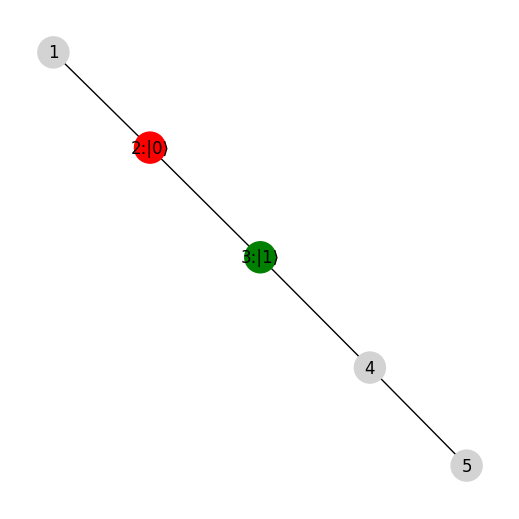

In [1]:
from vcgc.network import VCPNetwork

filename: str = "../data/benchmarks/linear_2_colored.col"

network = VCPNetwork(file_path=filename)

# Display the graph
network.draw_graph(name="../data/output/graph.png", node_size=500) # Draw nice graph using NetworkX